Vi starter med at definere en funktion for vores forsøg. En måling defineres som at slå med en terning N gange og lægge øjnene sammen. Dette gentages så 10 000 gange.

In [33]:
import numpy as np

np.random.seed(1)

# Kast en terning N gange og lægger øjnene sammen. Gentager dette 10 000 gange.
def diceroll(N):
    # Terningens egenskaber
    muligheder = [1,2,3,4,5,6]
    # Jeg har valgt ikke at vægte terningen, da det var svært at fitte normalfordelingen til en vægtet terning.
    sandsynligheder = [1/6, 1/6, 1/6, 1/6, 1/6, 1/6]
    # Laver N terningekast 10 000 gange
    kast_arr = np.random.choice(muligheder, (10000, N), p=sandsynligheder)
    # Lægger øjnene sammen
    return np.sum(kast_arr, axis = 1)
    



Tæthedsfunktionen for normalfordelingen.

In [34]:
# Normalfordelingen
def normal_distribution(x, sigma, mu, k):
    return (1/(sigma * np.sqrt(2*np.pi)))*np.exp((-(x-mu)**2)/2*(sigma**2)) * k


Hjælpefunktion til at afrunde til korrekt antal betydende cifre baseret på usikkerheden.\
\
Hentet fra [dette spørgsmål](https://stackoverflow.com/questions/53976847/report-uncertainty-given-a-mean-and-the-standard-error-show-only-significant-f) på stackoverflow.\
\
Der findes pakker der kan gøre det, men jeg kunne ikke være sikker på at det ville virke på en andens computer så jeg bruger denne metode i stedet for.

In [49]:
from decimal import Decimal
from IPython.display import Markdown as md, display_markdown

def round_uncert(value, uncertainty):
    # Fjerner nuller bag det sidste ciffer i usikkerheden
    u = Decimal(uncertainty).normalize()
    # Finder positionen af det første ciffer i usikkerheden
    exponent = u.adjusted()
    # Boolean der gemmer om det første ciffer af usikkerheden er 1
    precision = (u.as_tuple().digits[0] == 1)
    # Usikkerheden skaleres så dens første ciffer er det første/eneste tal før kommaet
    # Hvis det første ciffer er 1 afrundes til 1 decimal, ellers afrundes der til 0 decimaler.
    u = u.scaleb(-exponent).quantize(Decimal(10)**-precision)

    # Tallet skalere til samme tierpotens som usikkerheden og afrundes
    # Returnerer tallet, usikkerheden og tierpotens
    return round(Decimal(value).scaleb(-exponent).quantize(u)), u, exponent





Denne blok laver histogram/normalfordelingsfit for et givent N og plotter det. Desuden udregnes middelværdien.\
\
Bemærk at vi fitter til venstre kant af vores bins, da det får fittets middelværdi til at stemme overens med middelværdien fra vores datasæt. Hvis vi fittede til midten af binsne ville toppunktet af tæthedsfunktionen være forskudt 0.5 til højre for middelværdien.

In [54]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def dice_data(N):
    data = diceroll(N)

    # Udregn antal bins
    bin_num = np.arange(np.min(data),np.max(data)+2)

    # Lav histogrammet
    counts, bin_edges, patches = plt.hist(data, bins=bin_num, color="skyblue", alpha=0.8, label="Histogram", align="left")

    # Fjern den sidste kant for at N kanter at fitte til
    bin_corners = np.delete(bin_edges, -1)

    #plt.scatter(bin_centers, counts, color="r", marker=".")

    # Fit tæthedsfunktionen fra normalfordelingen til histogrammet
    # Startgæt
    sigma_g = 1
    # Vi sætter mu til det punkt der hører til midten af histogrammet (der hvor counts er højest)
    mu_g = float(bin_corners[np.where(counts == (max(counts)))])
    k_g = 1

    # For N = 1 er startgættene fundet ved at prøve sig frem
    if N == 1:
        sigma_g = 0.1
        mu_g = 3.5
        k_g = 0.1

    # Lav fit til normalfordelingen
    par, cov = curve_fit(normal_distribution, bin_corners, counts, p0=[sigma_g, mu_g, k_g], maxfev=100000)
    
    # Middelværdi og standardafvigelse findes ud fra parametrene fra fittet
    # Find middelværdi, standardafvigelse og usikkerhed på middelværdien
    mean = np.mean(data)
    std = np.std(data)
    mean_uncertainty = std / np.sqrt(len(data))

    rounded_mean = round_uncert(mean, mean_uncertainty)

    # Plot middelværdien med usikkerhed
    plt.axvline(mean, color="b", label="Middelværdi")
    plt.axvline(mean - mean_uncertainty, color="cyan", label="Usikkerhed på middelværdien")
    plt.axvline(mean + mean_uncertainty, color="cyan")
    
    # Plot tæthedsfunktionen
    X = np.linspace(0, max(bin_edges + 2), 100*len(data))
    plt.plot(X, normal_distribution(X, *par), color="r", linestyle='dashed', label="Fit til tæthedsfunktionen")

    plt.xlim(min(bin_edges - 1), max(bin_edges + 1))
    plt.title("Histogram over forsøg med N = {}".format(N))
    plt.grid()
    plt.legend()
    plt.show()

    # Vis middelværdi med usikkerhed
    display_markdown(md(r"Middelværdi af summen: $({} \pm {}) \cdot 10^{}$".format(rounded_mean[0], float(rounded_mean[1]), rounded_mean[2])))
    



In [37]:
# ( ͡° ͜ʖ ͡°)
np.random.seed(69)

Vi plotter plotsne.

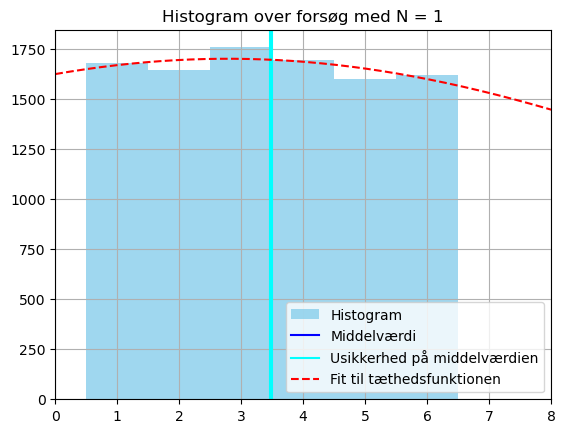

Middelværdi af summen: $(348 \pm 1.7) \cdot 10^-2$

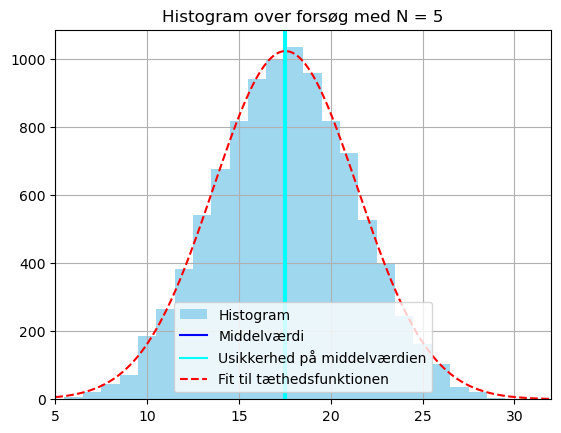

Middelværdi af summen: $(1752 \pm 4.0) \cdot 10^-2$

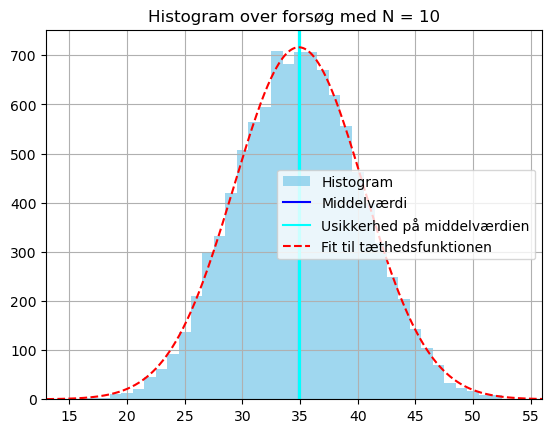

Middelværdi af summen: $(3493 \pm 5.0) \cdot 10^-2$

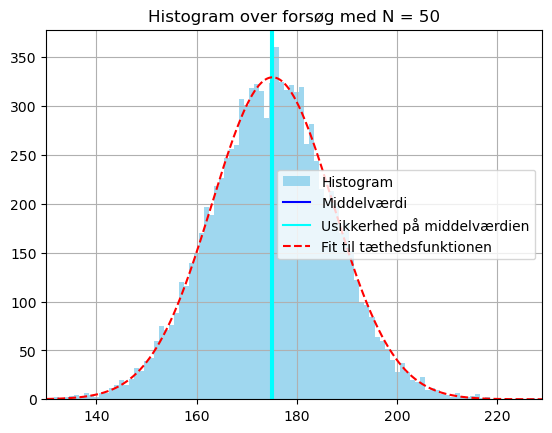

Middelværdi af summen: $(1750 \pm 1.2) \cdot 10^-1$

In [55]:
dice_data(1)
dice_data(5)
dice_data(10)
dice_data(50)